# Day 4: Intro to Grama

- Worked example
- Grama motivation
- Grama elements
- Exploratory model analysis


In [1]:
import grama as gr

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 6] # Need square aspect ratio for gradients to appear normal
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## Worked Example: Fitting a model

Load data


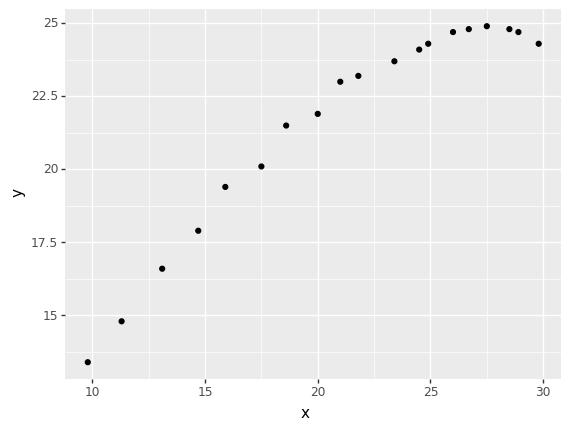

<ggplot: (8789784071025)>

In [2]:
## Load built-in dataset
from grama.data import df_trajectory_windowed

(
    df_trajectory_windowed
    >> ggplot(aes("x", "y"))
    + geom_point()
)

Suppose we want to make predictions on where the projectile will land; we'll need a *model*:

In [3]:
## Load built-in Grama model
from grama.models import make_trajectory_linear
md_traj = make_trajectory_linear()

## Print info about this model
md_traj.printpretty()


model: Trajectory Model

  inputs:
    var_det:
      t: [0, 600]
      u0: [0.1, inf]
      tau: [0.05, inf]
      v0: [0.1, inf]
    var_rand:
    copula:
        None
  functions:
    x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
    y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']


This is a model for a projectile's trajectory using Newton's laws and a linear drag model. The model takes in inputs `u0, v0, tau` (parameters) and the time `t` and outputs `x, y` coordinates.

Making a prediction with uninformed guesses will be terrible:

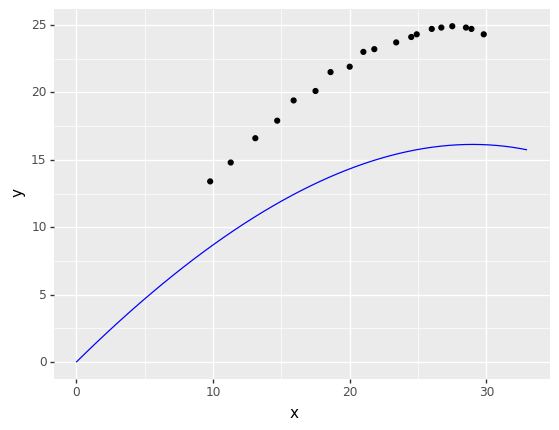

<ggplot: (8789786118585)>

In [4]:
## Need to set parameters for prediction:
u0 = 20 # initial horizontal velocity
v0 = 20 # initial vertical velocity  
tau = 5 # time constant (drag)

## Make a prediction with the model
df_prediction = gr.eval_df(
    md_traj,
    df=gr.df_make(u0=u0, v0=v0, tau=tau, t=np.linspace(0, 2))
)

## Visualize
(
    df_trajectory_windowed
    >> ggplot(aes("x", "y"))
    + geom_point()
    + geom_line(data=df_prediction, color="blue")
)

Use *nonlinear least squares* (NLS) to **optimize** the parameter values:


... fit_nls setting out = ['y', 'x']


model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)
    var_rand:
    copula:
        None
  functions:
    Fix variable levels: ['t'] -> ['u0', 'tau', 'v0']
    Trajectory Model: ['v0', 'u0', 'tau', 't'] -> ['y', 'x']


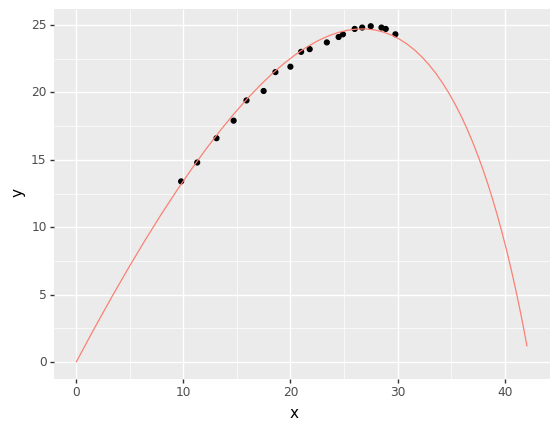

<ggplot: (8789786045049)>

In [5]:
## Fit the model
md_fit = gr.fit_nls(
    df_trajectory_windowed,
    md=md_traj,
    method="SLSQP",
    seed=101,
    verbose=False,
)
md_fit.printpretty()

## Make prediction with fitted model
df_pred_fit = gr.eval_df(
    md_fit,
    df=gr.df_make(t=np.linspace(0, 4.5))
)

## Visualize
(
    df_trajectory_windowed
    >> ggplot(aes("x", "y"))
    + geom_point()
    + geom_line(data=df_pred_fit, color="salmon")
)


## Grama Motivation

---

Idea: Have one computational object that you can use to encapsulate *many* of the assumptions and choices in quantitative modeling.

Some example modeling choices:
- Select the model inputs
- Specify bounds for the inputs
- Simplify the physics
- Fit a distribution for inputs

Grama is a software package to help make model building and analysis more transparent, convenient, and understandable.

Modeling in two phases:
- Model building
- Model analysis


### Model Building

---

Make a blank model


In [6]:
## Create a blank model
md = gr.Model("Base model")
## Print the details
md.printpretty()

model: Base model

  inputs:
    var_det:
    var_rand:
    copula:
        None
  functions:


Make a model with a function

In [7]:
## Create a blank model
md = gr.Model("Base model")
## Add a function
md = gr.comp_function(
    md, 
    fun=lambda X: X[0], # f(x) = x
    var=["x"],          # Inputs: x
    out=["f"],          # Outputs: f
)
## Print the details
md.printpretty()

model: Base model

  inputs:
    var_det:
      x: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['x'] -> ['f']


Make a model with function and variable bounds

In [8]:
## Create a blank model
md = gr.Model("Base model")
## Add a function
md = gr.comp_function(
    md, 
    fun=lambda X: X[0],
    var=["x"],
    out=["f"],
)
## Add a bound
md = gr.comp_bounds(
    md,
    x=(-1, +1),
)
## Print the details
md.printpretty()

model: Base model

  inputs:
    var_det:
      x: [-1, 1]
    var_rand:
    copula:
        None
  functions:
    f0: ['x'] -> ['f']


### Example: RLC circuit

**Model Functions**

Parallel RLC circuit: here are some key performance indicators of the circuit

$$\omega_0 = \sqrt{\frac{1}{LC}}$$

$$Q = \omega_0 RC.$$

**Model Domain**

Decide on a range of values for $R, L, C$ to test.

In [9]:
## Implement RLC Grama model
md_RLC = (
    gr.Model("RLC Circuit")
    ## Add the natural frequency
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            omega0=np.sqrt(1 / df.L / df.C)
        ),
        name="natural frequency",
        var=["L", "C"],
        out=["omega0"],
    )
    ## Add the Q factor
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            Q=df.omega0 * df.R * df.C
        ),
        name="quality factor",
        var=["omega0", "R", "C"],
        out=["Q"]
    )
    ## Set bounds for the input variables
    >> gr.cp_bounds(
        R=(1e-3, 1e0),  # resistance [ohm]
        L=(1e-9, 1e-3), # inductance [H]
        C=(1e-3, 10),   # capacitance [F]
    )
)

md_RLC.printpretty()

model: RLC Circuit

  inputs:
    var_det:
      C: [0.001, 10]
      L: [1e-09, 0.001]
      R: [0.001, 1.0]
    var_rand:
    copula:
        None
  functions:
    natural frequency: ['L', 'C'] -> ['omega0']
    quality factor: ['omega0', 'R', 'C'] -> ['Q']


**Remember**: You can always use `md.printpretty()` to inspect a model; see its inputs, outputs, function names, bounds/distribution.


## Model Analysis

Evaluate the model at specified `R,L,C` values:


In [10]:
gr.eval_df(
    md_RLC,
    df=gr.df_make(R=1000, L=0.1, C=0.1)
)


,R,L,C,omega0,Q
0,1000,0.1,0.1,10.0,1000.0


Fit the model to find `R,L,C` values for specified `omega0, Q`.

In [11]:
df_rlc = gr.eval_nls(
    md_RLC,
    df_data=gr.df_make(omega0=10, Q=1),
    n_restart=10
)
df_rlc


... eval_nls setting out = ['omega0', 'Q']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = []
Design runtime estimates unavailable; model has no timing data.


,C,L,R
0,10.000000,0.001,0.01
1,10.000000,0.001,0.01
2,10.000000,0.001,0.01
3,10.000000,0.001,0.01
4,10.000000,0.001,0.01
5,10.000000,0.001,0.01
6,10.000000,0.001,0.01
7,9.999994,0.001,0.01
8,10.000000,0.001,0.01
9,10.000000,0.001,0.01


Check that those values give the desired values


In [12]:
gr.eval_df(md_RLC, df=df_rlc)


,C,L,R,omega0,Q
0,10.000000,0.001,0.01,10.000004,0.999991
1,10.000000,0.001,0.01,10.000024,0.999998
2,10.000000,0.001,0.01,10.000029,0.999999
3,10.000000,0.001,0.01,10.000000,0.999999
4,10.000000,0.001,0.01,10.000026,0.999999
5,10.000000,0.001,0.01,10.000015,0.999998
6,10.000000,0.001,0.01,10.000008,1.000011
7,9.999994,0.001,0.01,10.000004,1.000007
8,10.000000,0.001,0.01,10.000016,1.000012
9,10.000000,0.001,0.01,10.000025,1.000000


## Grama Elements

---

Grama considers *data* and *models*. Data are organized into DataFrames, which are handled by the Pandas package.


In [13]:
df_example = pd.DataFrame(dict(
    x=[1, 2, 3],
    y=[0.1, 0.2, 0.3],
    z=["a", "b", "c"]
))
df_example


,x,y,z
0,1,0.1,a
1,2,0.2,b
2,3,0.3,c


DataFrames are useful because they're more human-readable than arrays. Each column has a name, so we can access specific columns with `df.variable`:

In [14]:
df_example.x


0    1
1    2
2    3
Name: x, dtype: int64

There are four fundamental Grama [verbs](https://py-grama.readthedocs.io/en/latest/source/language.html#verbs):

| Verb Type | Prefix (Short) | In | Out |
|---|---|---|---|
| Compose | `comp_` (`cp_`) | `md` | `md` |
| Evaluate | `eval_` (`ev_`) | `md` | `df` |
| Fit | `fit_` (`ft_`) | `df` | `md` |
| Transform | `tran_` (`tf_`) | `df` | `df` |
| Plot | `plot_` (`pt_`) | `df` | (Plot) |


### Compose

Used primarily to build up a model


In [15]:
## Create a blank model
md = gr.Model("Base model")
## Add a function
md = gr.comp_function(
    ## Take in function; will return modified
    md, 
    fun=lambda X: X[0],
    var=["x"],
    out=["f"],
)
## Print the details
md.printpretty()


model: Base model

  inputs:
    var_det:
      x: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['x'] -> ['f']


### Evaluate

Used to generate data from a model


In [16]:
df_result = gr.eval_df(
    ## Model to evaluate
    md,
    ## DataFrame at which to evaluate
    df=gr.df_make(x=[0, 1, 2])
)
df_result


,x,f
0,0,0.0
1,1,1.0
2,2,2.0


### Fit

Used to derive a model from data

First, set up a scenario with data and a model to fit:


In [17]:
## 
from grama.models import make_trajectory_linear
from grama.data import df_trajectory_windowed

md_trajectory = make_trajectory_linear()
md_trajectory.printpretty()

model: Trajectory Model

  inputs:
    var_det:
      t: [0, 600]
      u0: [0.1, inf]
      tau: [0.05, inf]
      v0: [0.1, inf]
    var_rand:
    copula:
        None
  functions:
    x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
    y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']


Fit the model


In [18]:
md_fit = gr.fit_nls(df_trajectory_windowed, md_trajectory)
md_fit.printpretty()

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
           u0   tau          v0  u0_0  tau_0  v0_0  success  \
0  425.160961  0.05  447.996073   0.1   0.05   0.1     True   

                                             message  n_iter       mse  
0  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...       6  25.49725  
model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)
    var_rand:
    copula:
        None
  functions:
    Fix variable levels: ['t'] -> ['u0', 'tau', 'v0']
    Trajectory Model: ['v0', 'u0', 'tau', 't'] -> ['y', 'x']


### Transform

Used to transform data


In [19]:
df_trajectory_windowed.head()


,t,x,y
0,0.6,9.8,13.4
1,0.7,11.3,14.8
2,0.8,13.1,16.6
3,0.9,14.7,17.9
4,1.0,15.9,19.4


Estimate time derivatives with finite differences


In [20]:
(
    df_trajectory_windowed
    >> gr.tf_mutate(
        # Estimate horizontal velocity
        #    (x1 - x0) / (t1 - t0)
        dxdt=(DF.x - gr.lag(DF.x)) / (DF.t - gr.lag(DF.t)),
        dydt=(DF.y - gr.lag(DF.y)) / (DF.t - gr.lag(DF.t)),
    )
    >> gr.tf_head()
)

,t,x,y,dxdt,dydt
0,0.6,9.8,13.4,NaN,NaN
1,0.7,11.3,14.8,15.0,14.0
2,0.8,13.1,16.6,18.0,18.0
3,0.9,14.7,17.9,16.0,13.0
4,1.0,15.9,19.4,12.0,15.0


## Exploratory Model Analysis

---

Grama is useful for *exploratory model analysis*; making sense of how a model behaves with respect to its inputs. Let's look at a simple model to build intuition.



$$f(x, a) = a \exp(x)$$

In [21]:
md_exponential = (
    ## Start an empty model
    gr.Model("Exponential model")
    ## Add in the function
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            f=df.a * np.exp(df.x)
        ),
        var=["a", "x"],
        out=["f"],
        name="Exponential"
    )
    ## Add some bounds
    >> gr.cp_bounds(
        a=(-1, +1),
        x=(-1, +1),
    )
)

md_exponential.printpretty()

model: Exponential model

  inputs:
    var_det:
      x: [-1, 1]
      a: [-1, 1]
    var_rand:
    copula:
        None
  functions:
    Exponential: ['a', 'x'] -> ['f']


Let's investigate the model with a *sinew* plot


Calling plot_sinew_outputs....


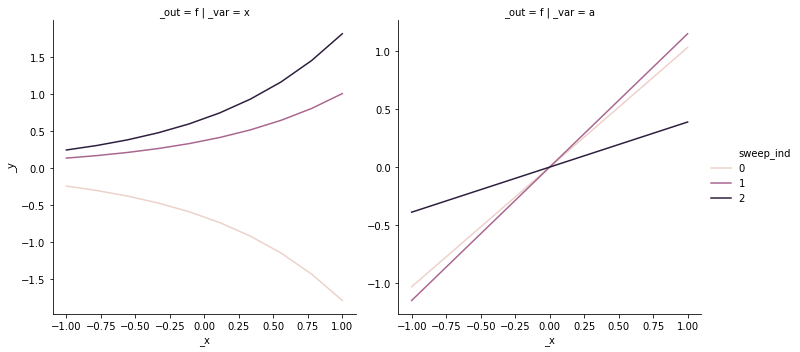

In [24]:
(
    md_exponential
    >> gr.ev_sinews(df_det="swp", seed=101)
    >> gr.pt_auto()
)

- input `a` has a linear effect on output `f`
- input `x` has an exponential effect on output `f`
  - direction is affected by `a`


Sinew plots especially useful for exploring a new model


Calling plot_sinew_outputs....


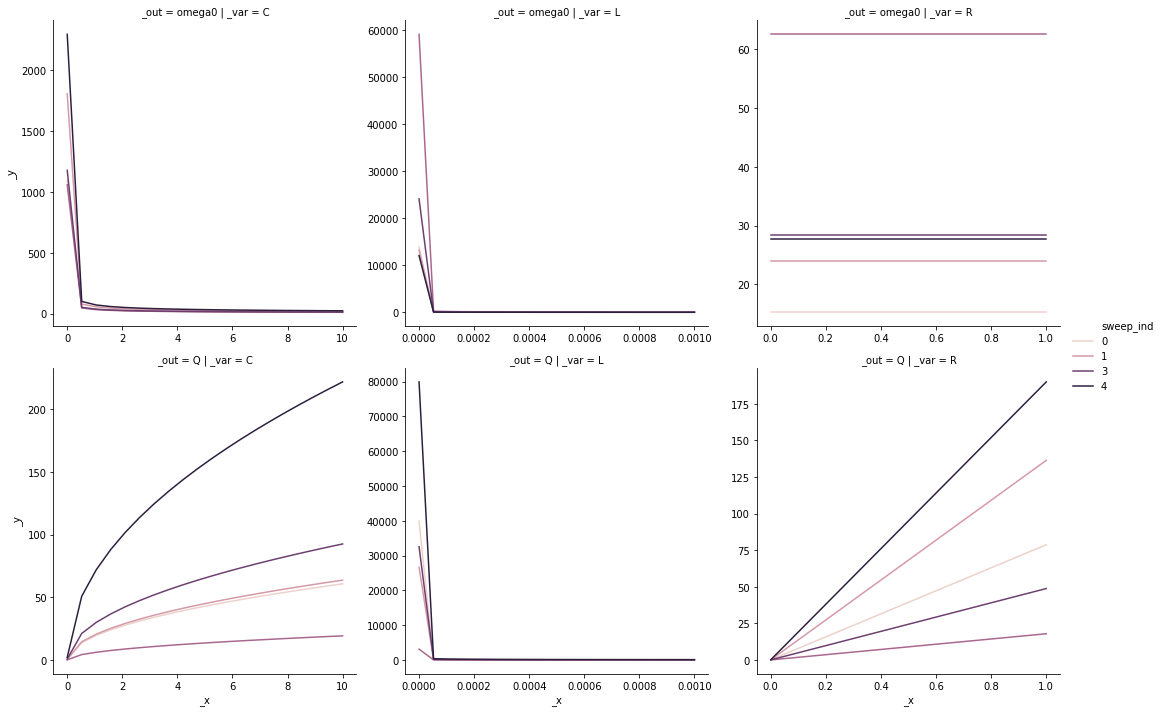

In [23]:
df_results = (
    md_RLC
    >> gr.ev_sinews(df_det="swp", n_density=20, n_sweeps=5, seed=101)
    >> gr.pt_auto()
)


- input `R` has a positive, linear effect on `Q`
- input `R` has zero effect on `omega0`
- input `C` has a positive, diminishing effect on `Q`
- input `C` has a negative, diminishing effect on `omega0`
- input `L` has a positive, diminishing effect on `Q`
- input `L` has a negative, diminishing effect on `omega0`
